<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# <br/>

$$ \Huge{\underline{\mathbf{ Model \ Free \ Control \ - \ Off \ Policy }}} $$

# Contents

* Intro
  * [Introduction](#Introduction)
  * [1D Corridor](#1D-Corridor) - same as [part 1](../Lecture05/ModelFreeControl_Part1.html)
  * [Helper Functions](#Helper-Functions) - same as [part 1](../Lecture05/ModelFreeControl_Part1.html)

* Expectation Based Methods
  * [Q-Learning]()
  * [Expected SARSA]()
  * [Tree Backup]() - multi-step Expected SARSA

* Importance Sampling Methods
  * [TD IS](#MC-Control) - MC prediction + $\epsilon$-greedy policy improvement
  * [MC IS](#MC-Prediction) - Monte Carlo with unweighted Importance Sampling
  * [N-Step IS]()
  
  
* On-Policy Control
  * [TD Prediction](#TD-Prediction) - Q version of TD(0) prediction
  * [SARSA](#SARSA) - TD(0) + $\epsilon$-greedy policy improvement = standard SARSA
  * [N-Step SARSA](#N-Step-SARSA) - n-step version of standard SARSA
* Off-Policy Control
  * [Expected SARSA](#Expected-SARSA) - off-policy version of standard SARSA using expectations (and n-step extension)
  * [Importance Sampling SARSA](#Importance-Sampling-SARSA) - off-policy SARSA using importance sampling (and n-step extensions, aka tree backup)

# Sources

* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 5 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
  * Lecture 5 vid: https://www.youtube.com/watch?v=0g4j2k_Ggc4
* Sutton and Barto 2018: http://incompleteideas.net/book/the-book-2nd.html

# Introduction

This post roughly corresponds to part 2 of Lecture 5 of UCL RL course by David Silver.

We will explore off-policy algorithms, as per vidoes like famous Q-Learning and Off-Policy MC. But we will also add more general versions that were excluded from videos, but I think will help understand whole picture. In addition we will look into Expected SARSA and Tree Backup algorithms.

As terminology can be a bit confusing, let's have a quick look at our little zoo of RL algorithms

<img src="assets/alg_zoo.png"/>
<center>Table: Numbers in bracket refer to chapters in Sutton and Barto 2018</center>
<center>Implementations in this notebook do not exactly correspond to the book</center>

<br/>

To better explain differences between On-Policy, Expectation and Importance Sampling, let's consider a mini-MDP below
<img src="assets/mini-mdp.png"/>
* agent starts in state START, then automatically picks action _forward_ (no choice here)
* after going forward, agent finds a gold coin (+1 reward) and ends up in a state ROOM
* from the ROOM, agent can go either _left_ or _right_ with probability determined by policy under consideration
* if agent goes _left_, then it ends up finding SMALL TREASURE (+10 reward), MDP terminates
* if agent goes _right_, then it finds LARGE TREASURE (+100 reward), MDP terminates
* mini-MDP is fully deterministic

Let's consider state-action values in reverse order:
* Assume all Q-values are initialised to zero
* Assume no discounting
* $Q(ROOM,left)$ or $Q(R,l)$ - as long as it is being explored, it will evaluate to corect value +10, and it doesn't depend on policy, this isn't very interesting
* $Q(ROOM,right)$ or $Q(R,r)$ - same as above
* $Q(START,forward)$ or $Q(S,f)$ - this one we are interested in. It very much depends on policy being executed, for example for random policy

$$ Q(S,f) = 1 + .5*Q(R,l) + .5*Q(R,r) = 1 + 5 + 50 = 56 $$

For each algorithm we will show different ways we can backup

$$ Q(S,f) \leftarrow Q(R,l), Q(R,r) $$

But first let's get some setup code out of the way

# 1D Corridor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

This is exactly the same as in [previous post](ModelFreeControl_Part1.html)
<img src="assets/corridor2.png"/>

In [2]:
class LinearEnv:
    """
    Allowed states are:
    State id: [ 0 ... 10 ]
    Type:     [ S ...  T ]
    Reward:   [-1 -1   0 ]
    """
    def __init__(self):
        size = 9
        self._max_left = 1      # last non-terminal state to the left
        self._max_right = size  # last non-terminal state to the right
        self._start_state = 0
        self.reset()

    def reset(self):
        self._state = self._start_state
        self._done = False
        return self._state

    def step(self, action):
        if self._done: return (self._state, 0, True)  # We are done
        if action not in [0, 1]: raise ValueError('Invalid action')

        self._state += -1 if action==0 else 1
        self._state = max(self._state, 0)   # bounce off the wall
        obs = self._state
        if self._state > self._max_right:
            reward = -1
            self._done = True
        elif self._state < self._max_left:
            reward = -1
            self._done = False
        else:
            reward = -1
            self._done = False
        return (obs, reward, self._done)

Approximations of true Q-values.

In [3]:
# Correct Q values for [0.50, 0.50] policy
REF_RANDOM = np.array([[-110.5532056 , -108.61773153],
                       [-110.65623192, -104.56492083],
                       [-108.50178808,  -98.41685263],
                       [-104.3888472 ,  -90.27064639],
                       [ -98.3192107 ,  -80.17634262],
                       [ -90.17318816,  -68.44749602],
                       [ -80.5422314 ,  -54.2499985 ],
                       [ -68.06102138,  -38.45003529],
                       [ -54.47164369,  -19.82526412],
                       [ -37.60231411,    0.        ],
                       [   0.        ,    0.        ]])

# Correct Q values for [0.00, 1.00] greedy policy
REF_GREEDY = np.array([[-10.,  -9.],
                       [-10.,  -8.],
                       [ -9.,  -7.],
                       [ -8.,  -6.],
                       [ -7.,  -5.],
                       [ -6.,  -4.],
                       [ -5.,  -3.],
                       [ -4.,  -2.],
                       [ -3.,  -1.],
                       [ -2.,   0.],
                       [  0.,   0.]])

Let's create environment and policies for future use

In [4]:
env = LinearEnv()

st_shape = [11]         # state space shape
st_act_shape = [11, 2]  # state-action shape
pi_random = np.tile([0.50, 0.50], [11, 1])  # starting random policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # optimal greedy policy

# Helper Functions

This is also exactly the same as in [previous post](ModelFreeControl_Part1.html)

In [10]:
def generate_episode(env, policy):
    """Generate one complete episode"""
    trajectory = []
    done = True
    for _ in range(1000):  # limit episode length
        # === time step starts ===
        if done:
            St, Rt, done = env.reset(), None, False
        else:
            St, Rt, done = env.step(At)   
        At = np.random.choice([0, 1], p=policy[St])
        trajectory.append((St, Rt, done, At))
        if done:
            break
        # === time step ends here ===
    return trajectory

In [12]:
class LogEntry:
    """Data log for one evaluation or training run, e.g. 100 episodes"""
    def __init__(self, type_, Q_hist, perf):
        self.type = type_     # string, e.g. 'monte carlo'
        self.Q_hist = Q_hist  # history of state-values
        self.perf = perf      # agent performance (episode length)

Plots two graphs:
* q-values after training is completed
* root-mean-squared-error (RMSE) during training process

In [14]:
def plot_experiments(log, truth_ref, plot_title):
    """Plot policy evaluation process
    
    Params:
        histories - list of 3d arrays, 
            each element is np.array, each np.array is independent eval or training run
            array dim 0 is number of episodes
            array dim 1 is Q-table (which is 2d on it's own) after each episode
        performances - list of 1d arrays
            each array is independent evaluation or training run
        truth_ref - precomputed correct Q-values
    """
    fig = plt.figure(figsize=[18,6])
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # plot ground truth
    ax1.plot(truth_ref[:-1,0], color='gray', linestyle='--')
    ax1.plot(truth_ref[:-1,1], color='gray', linestyle='--')
    
    for le in log:
        Q_vals = le.Q_hist[-1]
        ax1.plot(Q_vals[:-1,0], color='red', alpha=0.3)   # Q left
        ax1.plot(Q_vals[:-1,1], color='green', alpha=0.3) # Q right
        
        E_vals = np.sum(np.sum((truth_ref - le.Q_hist)**2, axis=-1), axis=-1)  # RMSE
        ax2.plot(E_vals, color='blue', alpha=0.3)         # RMSE
        
        ax3.plot(le.perf, color='blue', alpha=0.3)
        ax3.plot([0, len(perf)],[10,10], color='gray', linestyle='--')
    
    ax1.grid()
    ax1.set_title('Estimated State-Action Values')
    ax2.grid()
    ax2.set_title('Ground Truth Error')
    ax3.set_ylim([0, 1000])
    ax3.grid()
    ax3.set_title('Agent Performance')
    fig.suptitle(plot_title, fontsize=18)
                
    plt.show()

# On-Policy Control - SARSA

<img src="assets/mini-mdp.png"/>

This is what we explored in [previous post](ModelFreeControl_Part1.html). The main difference between SARSA, N-Step SARSA and MC Control is backup length. Other than that, the underlying principle is the same.
1. update Q-value estimation
2. update policy towards $\epsilon$-greedy

SARSA update formula

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) }\color{black}{} - Q(S_t,A_t) \big] $$

How does SARSA update $Q(S,f)$? By repeated sampling, for example for random policy sometimes we backup from $Q(R,l)$, sometimes from $Q(R,r)$. Becouse we update only a little bit (this is by $\alpha$) towards each target every time, value eventually settles on weighted average between $Q(R,l)$ and $Q(R,r)$ plus reward +1.

That is all nice and rosy as long as actually keep visiting all states. If policy is greedy, and it locks itself into always choosing left action before properly evauating $Q(R,r)$ then agent is doomed, it will never discover big treasure.

This demonstrates the main problem with on-policy methods. We have to use $\epsilon$-greedy policy to guarantee continous exploration. But when we use $\epsilon$-greedy agent will not achieve optimal performance. We could decay $\epsilon$ with time, but that brings practical issues with estabilishing correct schedule.

### Note on Exploring Starts

We could guarantee continous exploration by starting episode at random state and with random first action every time and then following given policy. This would guarantee all state-action pairs are evaluated, and subsequently fix the problem we encoutered above. After whole MDP is correctly evaulated we can switch off exploring starts and operate as normal in now solved MDP. This works disregarding if policy is greedy or not.

Problem with this is that it only works in small state spaces and usually can't be applied in real-world scenarios (how do you teleport robot into random initial states?).

In [7]:
def make_eps_greedy(Q, policy, eps):
    policy = np.zeros(shape=st_act_shape) + eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps
    return policy

In [20]:
def sarsa(env, policy, N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=st_act_shape)
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        
        policy = make_eps_greedy(Q, policy, eps)  # Make policy e-greedy

        hist.append(Q.copy())
        perf.append(len(trajectory)-1)
    return np.array(hist), np.array(perf)

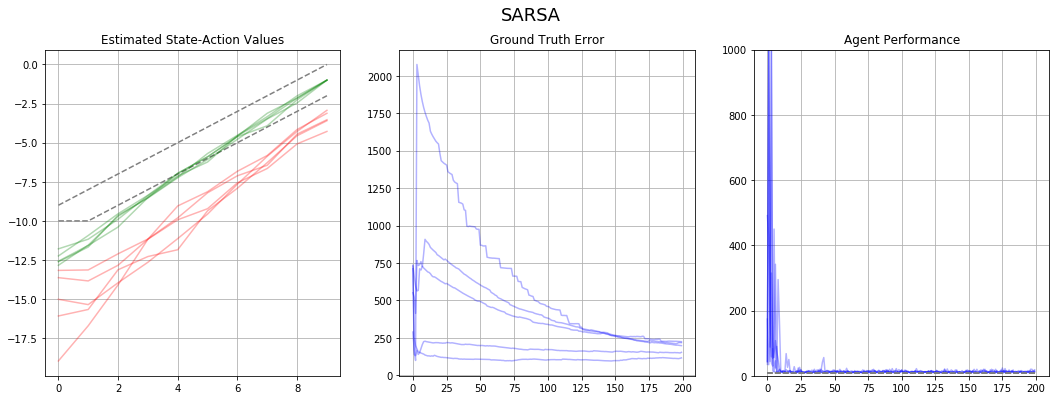

In [21]:
log = []
for _ in range(5):
    hist, perf = sarsa(env, pi_random, N=200, alpha=0.1, eps=0.1)
    log.append(LogEntry('sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA')

# Expected SARSA

Let's assume we are performing SARSA updates while following random policy. Let's also assume $Q(R,l)$ and $Q(R,r)$ have been correctly evaluated already. There is alternative way to backup $Q(S,f)$ from $Q(R,l)$ and $Q(R,r)$. Namely we know what policy we are following. We know we will pick $Q(R,l)$ 50% of a time and $Q(R,r)$ 50% of a time. Then why not backup towards weighted average stright away?

$$ Q(S,f) \leftarrow Q(S,f) + \alpha \big[ \color{blue}{R + \gamma\pi(l|R)Q(R,l)+\gamma\pi(r|R)Q(R,r)} \color{black}{} - Q(S,A) \big] $$

Or more generally

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma \sum_{a' \in A} \pi(a'|S_{t+1})Q(S_{t+1},a') }\color{black}{} - Q(S_t,A_t)) $$

But imagine we are doing a trial, agent is in state START and is about to pick action. What do we know? We know probability going letf is 50%, and probability going right is 50%. We also know both Q(ROOM,left) and Q(ROOM,right). So we can calculate expected value of Q(S',A') without doing any sampling!

$$ E_{rn}[Q(S',A')] = .5 * Q[ROOM,left] + .5 * Q[ROOM,right] = .5 * 10 + .5 * 100 = 55 $$

Of course we still need to sample a bit to learn about reward.

# - - - - - - 
.

.

.

.

.

.

.

.

.

..

.

.

.



.

..



.


.
.

.

.

.

..



.


# MC Prediction

Q-Value version of every-visit incremental monte-carlo. This is copy-paste of Incremental Monte-Carlo code from Model Free Prediction post Part 1 [link](../Lecture04_MFP/ModelFreePrediction_Part1.ipynb#Incremental-Monte-Carlo).

Changes are as follows:
* track Q-values (2d array) instead of V (1d-array)
* Gt calculation changed, this still assumes discount is always 1!
* update Q instead of V
* track history for plotting

Let's evaluate random policy. I got ground truth data by running this over 100k episodes
* state-action values should overlap with bottom-most gray ground-truth
* error to ground-truth for ranodm policy should decrease pretty quickly
* agent performance will not improve, becouse we are not actually improving policy

In [9]:
hist, perf = mc_prediction(N=100000, policy=pi_random)
plot_experiments([hist], [perf], REF_RANDOM, 'Random Policy')

ep  0
ep  1000
ep  2000
ep  3000
ep  4000
ep  5000
ep  6000
ep  7000
ep  8000
ep  9000
ep  10000
ep  11000
ep  12000
ep  13000
ep  14000
ep  15000
ep  16000
ep  17000
ep  18000
ep  19000
ep  20000
ep  21000
ep  22000
ep  23000
ep  24000
ep  25000
ep  26000
ep  27000
ep  28000
ep  29000
ep  30000
ep  31000
ep  32000
ep  33000
ep  34000
ep  35000
ep  36000
ep  37000
ep  38000
ep  39000
ep  40000
ep  41000
ep  42000
ep  43000
ep  44000
ep  45000
ep  46000
ep  47000
ep  48000
ep  49000
ep  50000
ep  51000
ep  52000
ep  53000
ep  54000
ep  55000
ep  56000
ep  57000
ep  58000
ep  59000
ep  60000
ep  61000
ep  62000
ep  63000
ep  64000
ep  65000
ep  66000
ep  67000
ep  68000
ep  69000
ep  70000
ep  71000
ep  72000
ep  73000
ep  74000
ep  75000
ep  76000
ep  77000
ep  78000
ep  79000
ep  80000
ep  81000
ep  82000
ep  83000
ep  84000
ep  85000
ep  86000
ep  87000
ep  88000
ep  89000
ep  90000
ep  91000
ep  92000
ep  93000
ep  94000
ep  95000
ep  96000
ep  97000
ep  98000
ep  99000


NameError: name 'REF_RANDOM' is not defined

In [11]:
hist[-1]

array([[-110.5532056 , -108.61773153],
       [-110.65623192, -104.56492083],
       [-108.50178808,  -98.41685263],
       [-104.3888472 ,  -90.27064639],
       [ -98.3192107 ,  -80.17634262],
       [ -90.17318816,  -68.44749602],
       [ -80.5422314 ,  -54.2499985 ],
       [ -68.06102138,  -38.45003529],
       [ -54.47164369,  -19.82526412],
       [ -37.60231411,    0.        ],
       [   0.        ,    0.        ]])

In [8]:
def mc_prediction(N, policy):
    hist, perf = [], []
    # C = np.zeros(obs_shape)  # old code
    # V = np.zeros(obs_shape)  # old code
    C = np.zeros(shape=[*obs_shape, 2])
    Q = np.zeros(shape=[*obs_shape, 2])

    for ep in range(N):
        trajectory = generate_episode(policy)
        for i in range(len(trajectory)-1):
            # Gt = trajectory[-1][1]  # old code
            Gt = -(len(trajectory)-i-2)  # -1 * nb_steps_to_end; assumes disc==1
            St, _, _, At = trajectory[i]
            
            C[St] += 1
            # V[St] = V[St] + (1/C[St]) * (Gt - V[St])  # old code
            Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])
            
        hist.append(Q.copy())
        perf.append(len(trajectory)-1)  # don't count terminal state
        
        if ep % 1000 == 0:
            print('ep ', ep)

    return np.array(hist), np.array(perf)

And skewed policy (this will be useful later)
* state-action values should overlap with middle ground-truth gray plot
* skewed policy has slightly higher probability of going right, so agent performance should be better

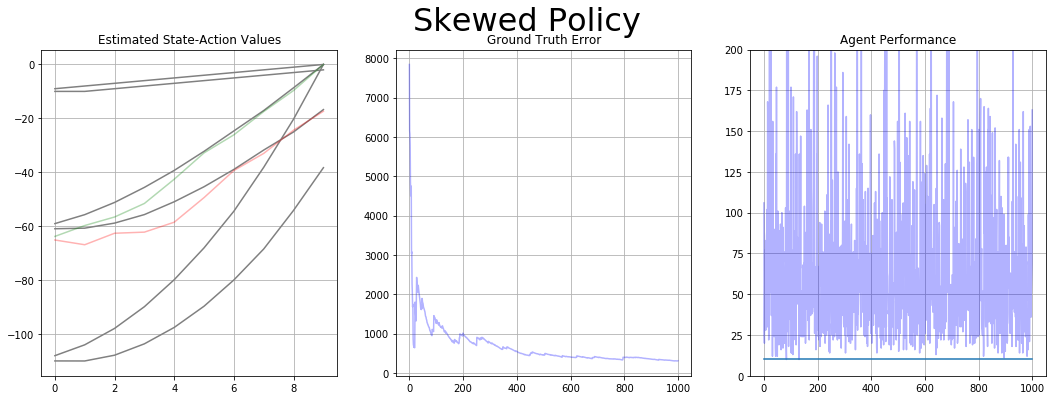

In [97]:
hist, perf = mc_prediction(N=1000, policy=pi_skewed)
plot_experiments([hist], [perf], REF_SKEWED, 'Skewed Policy')

And greedy policy.
* state-action values for right actions (green) overlap perfectly with gray line
* state-action values for left actions (red) completely failed to evalue (they are never taken during evaluation runs)
* agent performance is perfect, always -10 reward

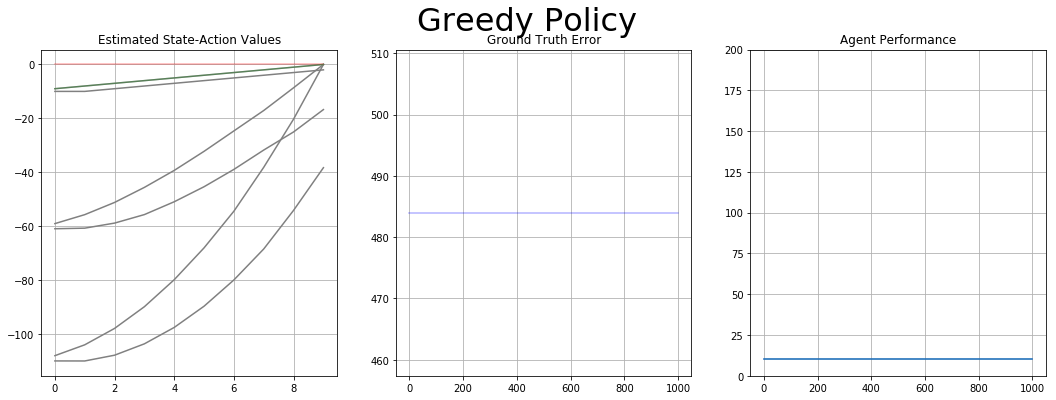

In [98]:
hist, perf = mc_prediction(N=1000, policy=pi_greedy)
plot_experiments([hist], [perf], REF_GREEDY, 'Greedy Policy')

# MC Control

We need a way to improve policy

In [53]:
def make_eps_greedy(Q, policy, eps):
    policy *= 0
    policy += eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps

This is a _running-mean_ version of MC code above. We need to track changing policy - incremental MC would keep action-values from early training episodes forever

In [101]:
def mc_control(N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=[*obs_shape, 2])
    policy = pi_random.copy()

    for ep in range(N):
        trajectory = generate_episode(policy)
        for i in range(len(trajectory)-1):
            Gt = -(len(trajectory)-i-2)  # -1 * nb_steps_to_end; assumes disc==1
            St, _, _, At = trajectory[i]
            # Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])  # old code
            Q[St, At] = Q[St, At] + alpha * (Gt - Q[St, At])  # replace 1/C with alpha
        
        make_eps_greedy(Q, policy, eps)  # Make policy e-greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory)-1)

    return np.array(hist), np.array(perf)

Let's run full training couple of times. Notice:
* right actions (left-plot, green) converge OK
* left actions (left-plot, red) take long to converge, becouse they are taken very rarely after policy is learned
* agent performance generally OK afeter training, high variance takes its tool

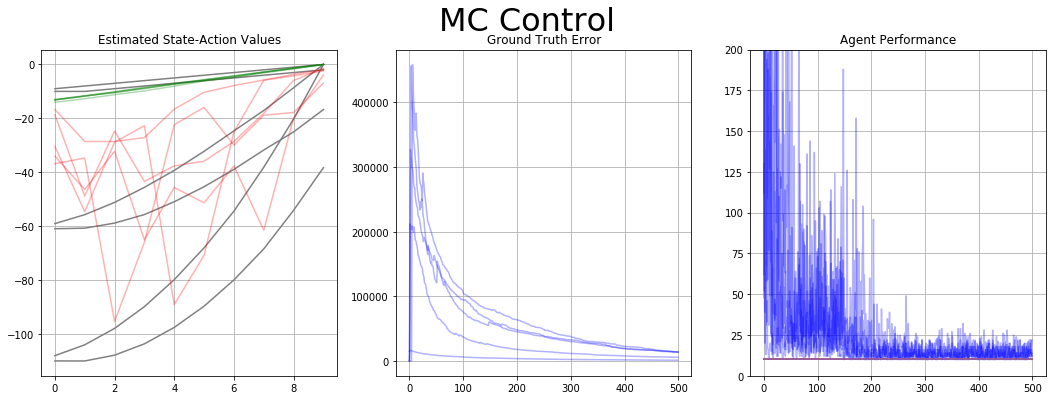

In [102]:
histories, performances = [], []
for _ in range(5):
    hist, perf = mc_control(N=500, alpha=0.01, eps=0.15)
    histories.append(hist)
    performances.append(perf)
plot_experiments(histories, performances, REF_GREEDY, 'MC Control')

# TD Prediction

In [19]:
def td0_experiment(N, alpha, policy):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

In [20]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_random)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Random', histories, REF_RANDOM)

NameError: name 'plot_experiments' is not defined

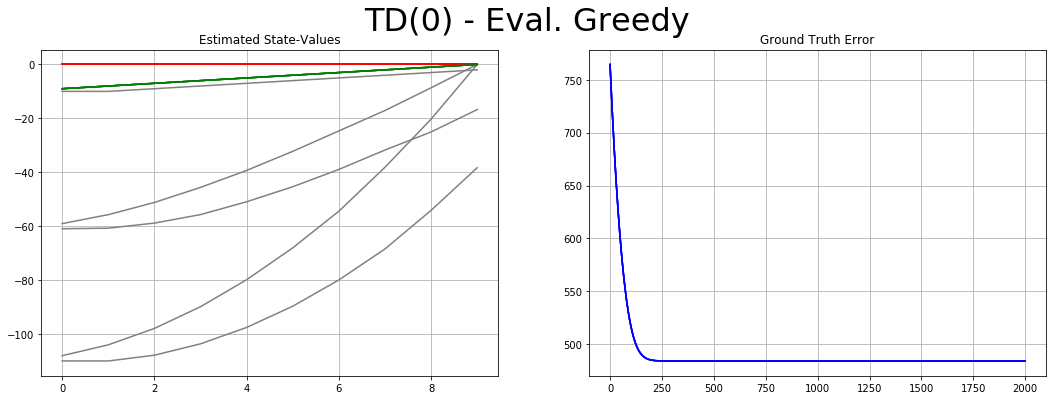

In [204]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_greedy)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)

### SARSA

$$ \color{red}{ TODO: tidy code! \\ remove \ holy \ cow} $$

In [292]:
def make_eps_greedy(Q, policy, eps):
    policy *= 0
    policy += eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps
    
def sarsa_experiment(N, alpha, policy):
    hist, perf = [], []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        make_eps_greedy(Q, policy, 0.15)
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!


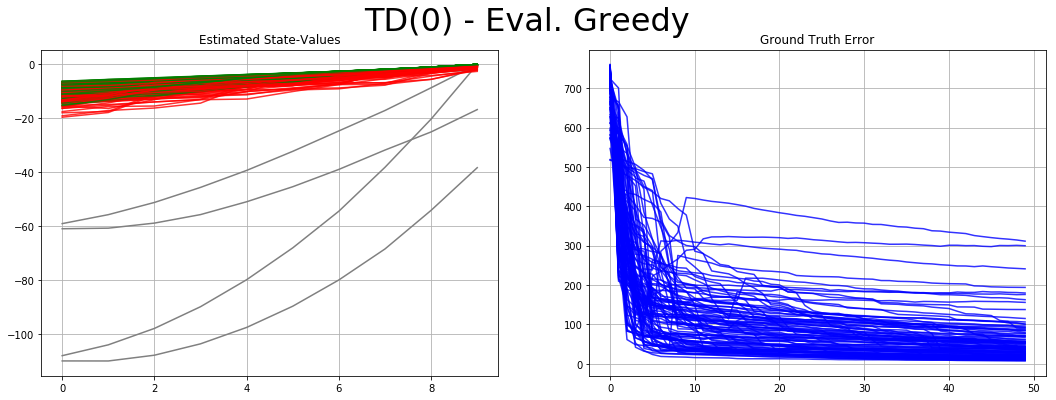

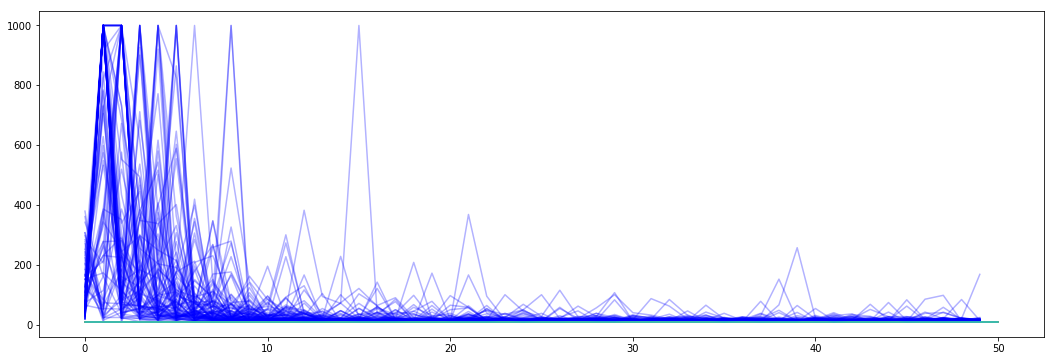

In [341]:
histories, performances = [], []
for _ in range(100):
    hist, perf = sarsa_experiment(N=50, alpha=0.05, policy=pi_random.copy())
    histories.append(hist)
    performances.append(perf)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)
fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(111)
for perf in performances:
    ax1.plot(perf, color='blue', alpha=0.3)
    ax1.plot([0, len(perf)],[10,10])

In [284]:
print(perf)
print(np.argmax(hist[-1], axis=-1))

[  78 1000 1000 1000  737 1000  134   89   93  421  226   47  297   87
   57   11   13   13   11   15   11   13   11   11   13   11   11   11
   13   16   11   11   11   13   11   13   13   11   11   11   11   11
   13   13   11   13   11   11   11   11   13   11   13   11   11   13
   14   13   11   13   15   11   11   15   12   11   13   11   11   11
   13   11   11   11   11   11   11   15   11   15   13   13   13   11
   11   11   13   11   13   13   11   13   15   11   11   11   13   11
   19   11]
[1 1 1 1 1 1 1 1 1 1 0]


### N-Step SARSA

In [296]:
def calc_Gt(trajectory, Q, t, disc, nstep=float('inf')):
    """Calculates return for state t, using n future steps.
    Params:
        traj - complete trajectory, each time-step should be tuple:
            (observation, reward, done, action)
        Q (float arr) - state-action-values, Q[term_state,:] must be zero!
        t (int [t, T-1]) - calc Gt for this time step in trajectory,
            0 is initial state; T-1 is last non-terminal state
        disc - discrount, usually noted as gamma
        n (int or +inf, [1, +inf]) - n-steps of reward to accumulate
                If n >= T then calculate full return for state t
                For n == 1 this equals to TD return
                For n == +inf this equals to MC return
    """

    T = len(trajectory)-1   # terminal state
    max_j = min(t+nstep, T) # last state iterated, inclusive
    tmp_disc = 1.0          # this will decay with rate disc
    Gt = 0                  # result

    # Iterate from t+1 to t+nstep or T (inclusive on both start and finish)
    for j in range(t+1, max_j+1):
        Rj = trajectory[j][1]  # traj[j] is (obs, reward, done, action)
        Gt += tmp_disc * Rj
        tmp_disc *= disc

    # Note that Q[Sj, Aj] will have state-value of state t+nstep or
    # zero if t+nstep >= T as V[St=T] must equal 0
    Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
    Gt += tmp_disc * Q[Sj, Aj]

    return Gt

In [344]:
def nstep_sarsa_experiment(N, alpha, policy):
    hist, perf = [], []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            Gt = calc_Gt(trajectory, Q, t, disc=1.0, nstep=2)
            target = Gt
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        make_eps_greedy(Q, policy, 0.15)
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!


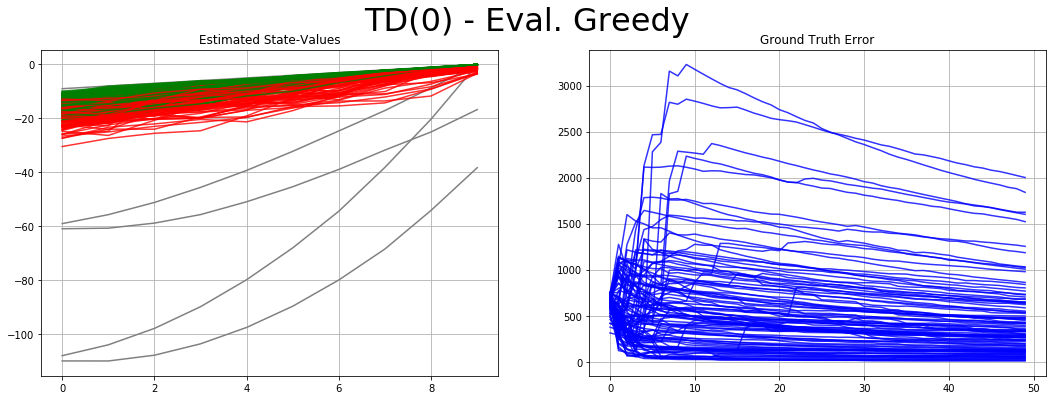

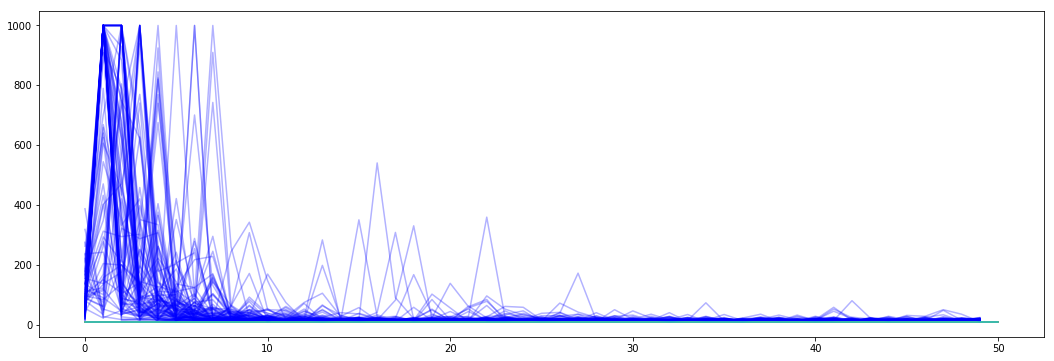

In [345]:
histories, performances = [], []
for _ in range(100):
    hist, perf = nstep_sarsa_experiment(N=50, alpha=0.05, policy=pi_random.copy())
    histories.append(hist)
    performances.append(perf)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)
fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(111)
for perf in performances:
    ax1.plot(perf, color='blue', alpha=0.3)
    ax1.plot([0, len(perf)],[10,10])

# TD(0) - with Expected Return

In [205]:
def exp_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Q[St_1, At_1]  # sarsa
            target = pol_tar[St, 0]*Q[St_1, 0] + pol_tar[St, 1]*Q[St_1, 1]  # exp sarsa
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

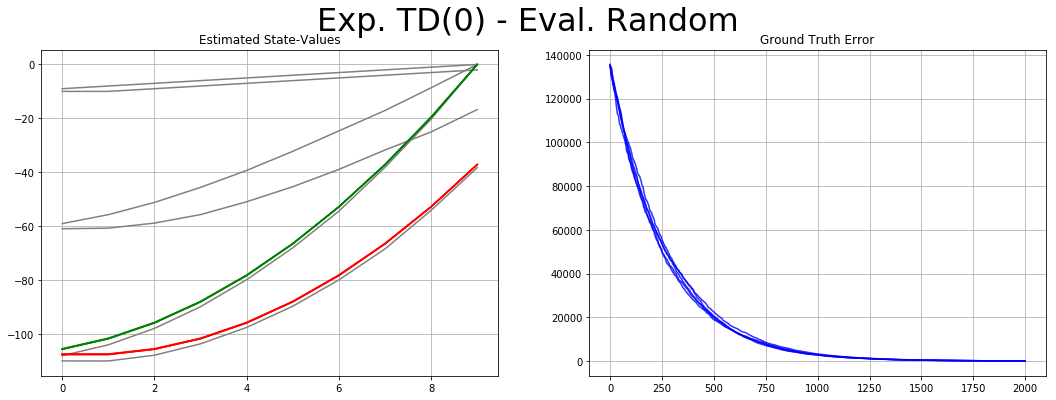

In [206]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Random', histories, REF_RANDOM)

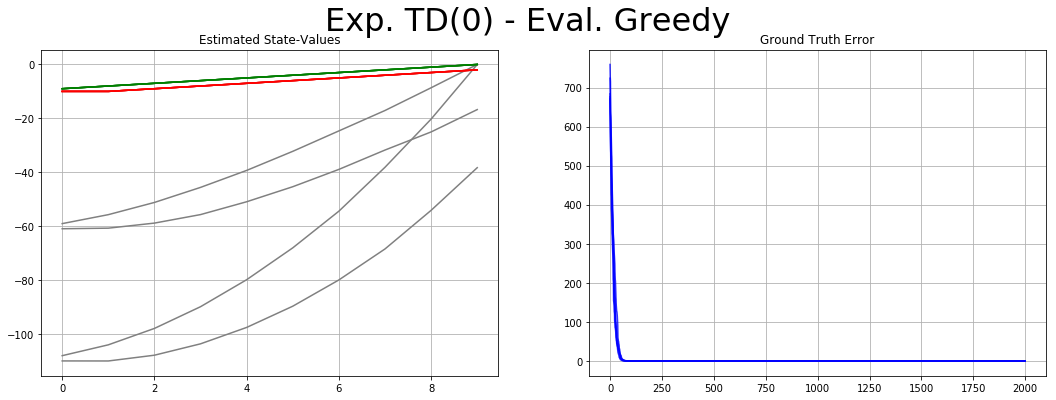

In [207]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Greedy', histories, REF_GREEDY)

# TD(0) with Importance Sampling

In [208]:
def is_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = (pol_tar[St, At] / pol_beh[St, At]) * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

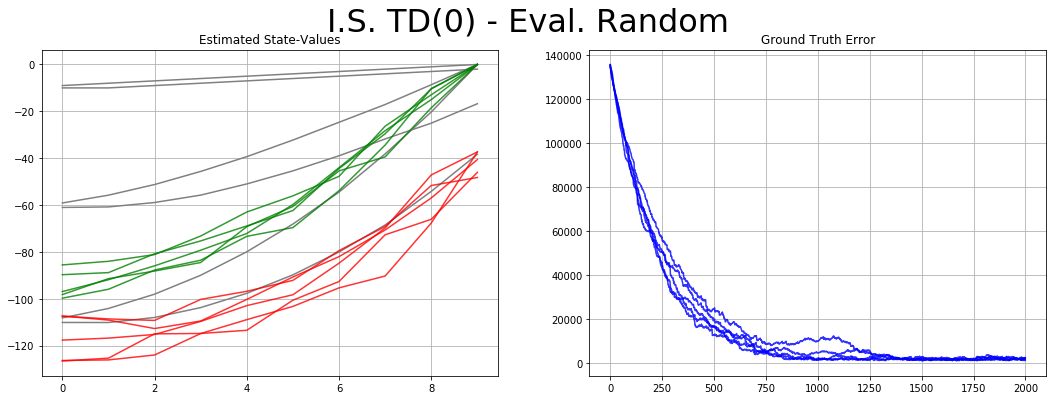

In [210]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Random', histories, REF_RANDOM)

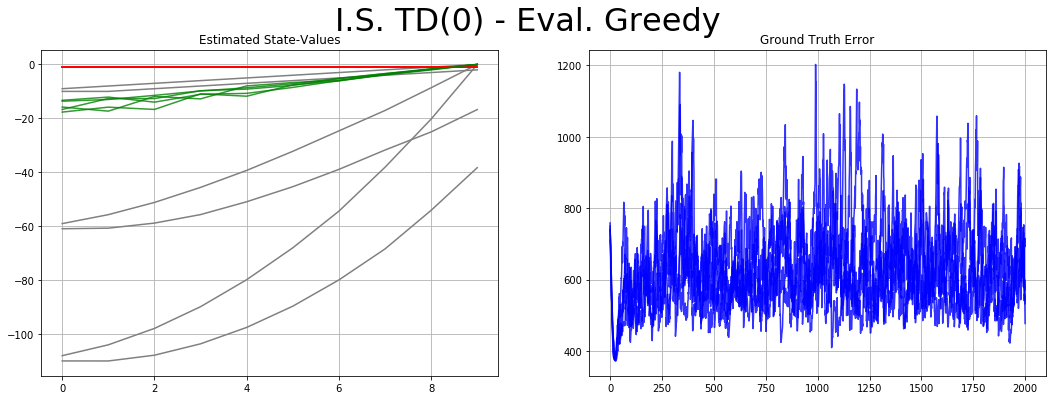

In [211]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Greedy', histories, REF_GREEDY)


To better explain different algorithms, let's consider following mini-MDP

<img src="assets/mini-mdp.png"/>



And let us define three policies:

| Policy       |  P(A=left) | P(A=right) | Q(ROOM,left) | Q(ROOM,right) | V(ROOM) | Q(START,forward) | V(START) |
|-|-|-|-|-|-|-|-|
| Random       |     50%    |     50%    |      10      |      100      |    55   |        56        |     56   |
| Skewed-Right |     40%    |     60%    |      10      |      100      |    64   |        65        |     65   |
| Greedy-Right |      0%    |    100%    |      10      |      100      |   100   |       111        |    111   |

In case of greedy policy, if both left & right Q-values are equal (e.g. when we initialise to zero), then tie is broken randomly with equal probability.

The evaulation of the policies should be trivial:
* Q(ROOM, left) - agent always finds small treasure, so that's 10
* Q(ROOM, right) - agent always finds large treasure, that's 100
* V(ROOM) - this one depends on policy
  * Random policy - agent takes left 50% of a time (50% \* 10) and right 50% of a time (50% \* 100), so $ V_{rn}(ROOM) = 0.5*10 + 0.5*100 = 55 $
  * Skewed policy - agent takes left 40% of a time (40% \* 10) and right 60% of a time (60% \* 100), so $ V_{sk}(ROOM) = 0.4*10 + 0.6*100 = 64 $
  * Greedy policy - agent takes left 0% of a time (0% \* 10) and right 100% of a time (100% \* 100), so $ V_{gr}(ROOM) = 0.0*10 + 1.0*100 = 100 $
* Q(START,forward) - same as above, but include +1 reward for gold coin
* V(START) - same as Q(START,forward)

Ok, let's now see how different algorithms perform backups.

### On-Policy Control - SARSA
This is what we explored in [previous post](ModelFreeControl_Part1.html).

Update formula

$$ Q(S,A) \leftarrow Q(S,A) + \alpha(R + \gamma(Q(S',A') - Q(S,A)) $$

__Random Policy__
* first let's focus on Q(ROOM,left) and Q(ROOM,right) - these are final state-action pairs, there is no more actions to be taken. Backup from terminal state will involve only final reward. Q(S',A') is always zero for terminal states. Notice that it doesn't matter which policy agent is following. As long as agent visits these states enough times, so it can sample rewards properly, then Q(ROOM,left) and Q(ROOM,right) will be eventually correctly approximated.
* we will ignore V(ROOM) since we are working with Q-values for control
* Q(START,forward) - let's assume Q(ROOM,left) and Q(ROOM,right) are already correctly evaluated and that we do further 1000 trials. Because policy is random, we will take left action approximately 500 times, and right action approximately 500 times. Hence we will update 500 times towards target=1+10 (don't forget gold coin), and 500 times towards target=1+100. Final estimate will settle in between of the two, which is 56 (wheather this is actually true depends how close estimate is when we started 1000 trials, and what is the step-size $\alpha$)

__Skewed Policy__
* for Q(ROOM,left) and Q(ROOM,right) situation is the same as with random policy. Q(ROOM,right) will get evaluated correctly sooner, because it is visited more often, but eventually both will settle on correct values
* for Q(START,forward) - as before let's assume Q(ROOM,left) and Q(ROOM,right) are already correctly evaluated and that we make further 1000 trials. We will update approx 400 times towards target=1+10, and approx 600 times towards target=1+100. Because we update slightly more often towards target=100 final estimate will be biased towards that value and settle around 65.

__Greedy Policy__
* Let's assume that on first trial ever, when picking between left and right, tie is broken towards left action (initially both Q(ROOM,left) and Q(ROOM,right) are equal zero). On that first trial Q(ROOM,left) will be updated towards target=10. From now on Q(ROOM,left) > 0, and Q(ROOM,right) == 0. Greedy policy will always pick left action. This clearly does not work.

This demonstarted the main problem with on-policy methods. We have to use $\epsilon$-greedy policy to guarantee continous exploration. But when we use $\epsilon$-greedy agent will not achieve optimal performance. We could decay $\epsilon$ with time, but that brings practical issues with estabilishing correct schedule.



### Off-Policy with Expectations

Let's assume we are performing SARSA updates while following random policy. Let's also assume Q(ROOM,left) and Q(ROOM,right) have been correctly evaluated already. This leaves problem of evaluating Q(START,forward). Normally we would do 1000 trials, update Q(START,forward) sometimes towards target=1+10, sometimes towards target=1+100 and final estimate would settle on 56 (55 average +1 gold coin).

But imagine we are doing a trial, agent is in state START and is about to pick action. What do we know? We know probability going letf is 50%, and probability going right is 50%. We also know both Q(ROOM,left) and Q(ROOM,right). So we can calculate expected value of Q(S',A') without doing any sampling!

$$ E_{rn}[Q(S',A')] = .5 * Q[ROOM,left] + .5 * Q[ROOM,right] = .5 * 10 + .5 * 100 = 55 $$

Of course we still need to sample a bit to learn about reward.